In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/Colab_Files/FMD.zip" -d FMD

Archive:  /content/drive/My Drive/Colab_Files/FMD.zip
   creating: FMD/mask/
   creating: FMD/mask/fabric/
  inflating: FMD/mask/fabric/fabric_moderate_001_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_002_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_003_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_004_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_005_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_006_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_007_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_008_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_009_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_010_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_011_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_012_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_013_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_014_new.jpg  
  inflating: FMD/mask/fabric/fabric_moderate_015_new.jpg  
  inflat

In [3]:
!ls FMD -lah

total 16K
drwxr-xr-x  4 root root 4.0K Nov 21 03:30 .
drwxr-xr-x  1 root root 4.0K Nov 21 03:30 ..
drwxr-xr-x 12 root root 4.0K Nov 20  2009 image
drwxr-xr-x 12 root root 4.0K Jun  8  2010 mask


In [4]:
!nvidia-smi

Sat Nov 21 03:30:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
import pathlib

data_dir = pathlib.Path("FMD/image")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1000


100


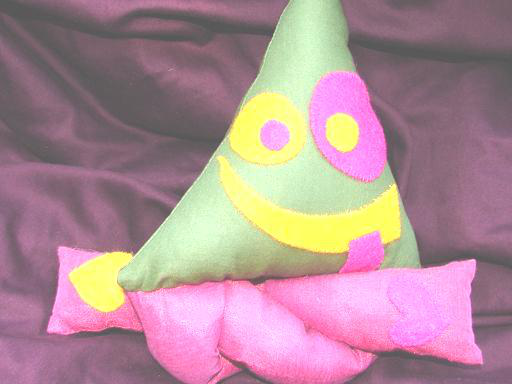

In [7]:
fabrics = list(data_dir.glob('fabric/*.jpg'))
print(len(fabrics))
PIL.Image.open(str(fabrics[0]))

In [8]:
batch_size = 16
img_height = 299
img_width = 299

In [9]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['fabric' 'foliage' 'glass' 'leather' 'metal' 'paper' 'plastic' 'stone'
 'water' 'wood']


In [10]:
ds_each_class = [tf.data.Dataset.list_files(str(data_dir/f'{class_name}/*.jpg'), shuffle=False) for class_name in class_names]

for index, ds in enumerate(ds_each_class):
  ds_each_class[index] = ds.shuffle(image_count//10, seed=123, reshuffle_each_iteration=False)

In [11]:
for f in ds_each_class[0].take(10):
  print(f.numpy())

for f in ds_each_class[1].take(10):
  print(f.numpy())

b'FMD/image/fabric/fabric_moderate_037_new.jpg'
b'FMD/image/fabric/fabric_moderate_004_new.jpg'
b'FMD/image/fabric/fabric_moderate_008_new.jpg'
b'FMD/image/fabric/fabric_object_003_new.jpg'
b'FMD/image/fabric/fabric_object_017_new.jpg'
b'FMD/image/fabric/fabric_object_001_new.jpg'
b'FMD/image/fabric/fabric_moderate_032_new.jpg'
b'FMD/image/fabric/fabric_moderate_030_new.jpg'
b'FMD/image/fabric/fabric_moderate_038_new.jpg'
b'FMD/image/fabric/fabric_object_009_new.jpg'
b'FMD/image/foliage/foliage_final_037_new.jpg'
b'FMD/image/foliage/foliage_final_004_new.jpg'
b'FMD/image/foliage/foliage_final_008_new.jpg'
b'FMD/image/foliage/foliage_final_053_new.jpg'
b'FMD/image/foliage/foliage_final_067_new.jpg'
b'FMD/image/foliage/foliage_final_051_new.jpg'
b'FMD/image/foliage/foliage_final_032_new.jpg'
b'FMD/image/foliage/foliage_final_030_new.jpg'
b'FMD/image/foliage/foliage_final_038_new.jpg'
b'FMD/image/foliage/foliage_final_059_new.jpg'


In [12]:
# split first class dataset into 5 equal sized parts for 5-fold cross validation
A = ds_each_class[0].shard(num_shards=5, index=0)
B = ds_each_class[0].shard(num_shards=5, index=1)
C = ds_each_class[0].shard(num_shards=5, index=2)
D = ds_each_class[0].shard(num_shards=5, index=3)
E = ds_each_class[0].shard(num_shards=5, index=4)
for i in range(1, 10):
  A = A.concatenate(ds_each_class[i].shard(num_shards=5, index=0))
  B = B.concatenate(ds_each_class[i].shard(num_shards=5, index=1))
  C = C.concatenate(ds_each_class[i].shard(num_shards=5, index=2))
  D = D.concatenate(ds_each_class[i].shard(num_shards=5, index=3))
  E = E.concatenate(ds_each_class[i].shard(num_shards=5, index=4))

In [13]:
print(A.cardinality().numpy())
print(B.cardinality().numpy())
print(C.cardinality().numpy())
print(D.cardinality().numpy())
print(E.cardinality().numpy())

200
200
200
200
200


In [14]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [15]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [16]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
A = A.map(process_path, num_parallel_calls=AUTOTUNE)
B = B.map(process_path, num_parallel_calls=AUTOTUNE)
C = C.map(process_path, num_parallel_calls=AUTOTUNE)
D = D.map(process_path, num_parallel_calls=AUTOTUNE)
E = E.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
for image, label in A.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  0


In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [21]:
ds_fold_dict = {0:A, 1:B, 2:C, 3:D, 4:E}

In [22]:
preprocess_input = keras.applications.xception.preprocess_input

In [23]:
base_learning_rate = 0.0001
def create_model(base_model):
  data_augmentation = keras.Sequential(
    [
      layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                  input_shape=(img_height, 
                                                                img_width,
                                                                3)),
      layers.experimental.preprocessing.RandomRotation(0.1),
      layers.experimental.preprocessing.RandomZoom(0.1),
    ]
  )

  global_average_layer = keras.layers.GlobalAveragePooling2D()
  fully_connected_layer = keras.layers.Dense(128, activation='relu')
  prediction_layer = keras.layers.Dense(10)

  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = keras.layers.Dropout(0.2)(x)
  x = fully_connected_layer(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = keras.Model(inputs, outputs)
  optimizer = keras.optimizers.Adam(lr=base_learning_rate)
  loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  model.summary()
  return model

In [24]:
no_epochs = 50
fine_tune_epochs = 20
total_epochs =  no_epochs + fine_tune_epochs
# Fine-tune from this layer onwards
fine_tune_at = 115

In [25]:
history_map = {}
base_model_acc_list = []
pre_trained_acc_list = []
final_acc_list = []

for i in range(5):
  print('fold', i + 1)
  temp_dict = ds_fold_dict.copy()
  # get test set for this iteration
  current_val_ds = temp_dict[i]

  # get training set for this iteration from remaining data samples
  del temp_dict[i]
  current_train_ds = None
  for ds_shard in temp_dict.values():
    if current_train_ds is None:
      current_train_ds = ds_shard
    else:
      current_train_ds = current_train_ds.concatenate(ds_shard)
  
  current_train_ds = configure_for_performance(current_train_ds)
  current_val_ds = configure_for_performance(current_val_ds)

  # get pre-trained model
  base_model = keras.applications.Xception(include_top=False, input_shape=(img_height, img_width, 3))
  # don't train base model weights
  base_model.trainable = False

  # create a new model
  model = create_model(base_model)
  # get initial test accuracy
  base_model_acc_list.append(model.evaluate(current_val_ds)[1])
  # train for specified epochs
  history = model.fit(current_train_ds,
                    epochs=no_epochs,
                    validation_data=current_val_ds)
  
  # get test accuracy before fine-tuning
  pre_trained_acc_list.append(model.evaluate(current_val_ds)[1])

  # start fine-tuning
  base_model.trainable = True

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  optimizer = keras.optimizers.RMSprop(lr=base_learning_rate/10)
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  print('Fine-tuned model:')
  model.summary()

  # train fine-tuned model
  history_fine = model.fit(current_train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=current_val_ds)

  # save results
  if i == 0:
    history_map['accuracy'] = [history.history['accuracy'] + history_fine.history['accuracy']]
    history_map['val_accuracy'] = [history.history['val_accuracy'] + history_fine.history['val_accuracy']]
    history_map['loss'] = [history.history['loss'] + history_fine.history['loss']]
    history_map['val_loss'] = [history.history['val_loss'] + history_fine.history['val_loss']]
  else:
    history_map['accuracy'].append(history.history['accuracy'] + history_fine.history['accuracy'])
    history_map['val_accuracy'].append(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
    history_map['loss'].append(history.history['loss'] + history_fine.history['loss'])
    history_map['val_loss'].append(history.history['val_loss'] + history_fine.history['val_loss'])
  
  # get final test accuracy
  final_acc_list.append(np.amax(history.history['val_accuracy']+history_fine.history['val_accuracy']))

fold 1
83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
________________________________________________

In [26]:
print("Base model accuracy:", np.mean(base_model_acc_list))
print("Accuracy before fine-tuning:", np.mean(pre_trained_acc_list))
print("Final accuracy:", np.mean(final_acc_list))

Base model accuracy: 0.09300000071525574
Accuracy before fine-tuning: 0.8400000095367431
Final accuracy: 0.8639999985694885


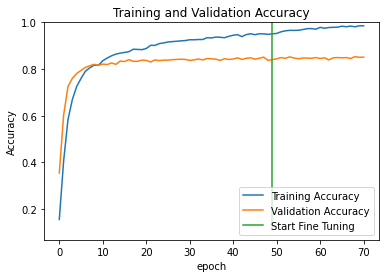

In [27]:
acc = np.mean(history_map['accuracy'], axis=0)
val_acc = np.mean(history_map['val_accuracy'], axis=0)

plt.figure(1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([no_epochs-1,no_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/Colab_Files/cv_acc_xception_balanced_modified_fine_tuned.jpg')
plt.show()

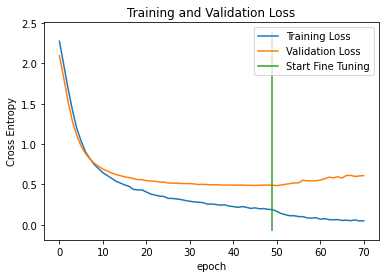

In [28]:
loss = np.mean(history_map['loss'], axis=0)
val_loss = np.mean(history_map['val_loss'], axis=0)

plt.figure(2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([no_epochs-1,no_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/Colab_Files/cv_loss_xception_balanced_modified_fine_tuned.jpg')
plt.show()

In [29]:
drive.flush_and_unmount()